In [1]:
## Darwinian shift available at: https://github.com/michaelhall28/darwinian_shift
import pandas as pd
import darwinian_shift
import re
import numpy as np

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
## Load a bunch of useful functions and hacks to the darwinian shift code to allow us to do some nice plotting
def one_to_three(one_letter_code):
   ##converts any one letter code 
   ##    to a three letter code
    mapping = {'A':'Ala',
               'R':'Arg',
               'N':'Asn',
               'D':'Asp',
               'C':'Cys',
               'Q':'Gln',
               'E':'Glu',
               'G':'Gly',
               'H':'His',
               'I':'Ile',
               'L':'Leu',
               'K':'Lys',
               'M':'Met',
               'F':'Phe',
               'P':'Pro',
               'S':'Ser',
               'T':'Thr',
               'W':'Trp',
               'Y':'Tyr',
               'V':'Val',}
    return mapping[one_letter_code.upper()].upper()

def plot_boxplot2(self, spectra=None, plot_scale=None, show_plot=False, colours=None,
                     figsize=(5, 5), return_fig=False, ax=None):
        """
        Boxplot of the expected and observed distributions of mutation scores.
        :param spectra: The mutational spectrum or list of mutational spectra to use.
        :param plot_scale:  Scale for the y-axis (mutation scores). Passed to matplotlib. 'log', 'symlog' etc.
        :param show_plot: If True, will call plt.show().
        :param colours: List of colours. First colour is for the observed data, the subsequent colours are
        for plotting the null distributions from each of the mutational spectra given.
        :param figsize: Size of the figure.
        :param return_fig: If True, will return the figure. Used for testing.
        :param ax: Matplotlib axis to plot on. If None, will create a new figure.
        :return: By default, None. If return_fig=True, will return the figure.
        """
#        if ax is None:
#            fig, ax = plt.subplots(figsize=figsize)
#        else:
#            fig = ax.figure

        spectra = self._get_spectra(spectra)

        colours = self._get_plot_colours(colours, len(spectra)+1)
        data = [get_distribution_from_mutational_spectrum(self.null_scores,
                                                          self.null_mutations[spectrum.rate_column])
                for spectrum in spectra]
        data.append(self.observed_values)
        
        return(data)
    
    
def get_distribution_from_mutational_spectrum(values, mut_rates, num=1000000):
    mut_rates = np.array(mut_rates)
    weights = mut_rates / mut_rates.sum()
    dist = np.repeat(values, np.random.multinomial(num, weights))
    return dist

## Setting up data for darwinian shift

In [3]:
## We set up the files for darwinian shift to read
mutationdata = pd.read_csv("./Foldx/6I41/chainA/SPOP_binding_DDG.txt")

In [4]:
mutationdata.head()

,Unnamed: 0,0,Mutation,WT_energy,MUT_energy,DDG
0,0,1,YA87S,-12.8906,-8.65216,4.23844
1,1,2,YA87R,-12.8947,-11.52480,1.36990
2,2,3,YA87C,-12.8906,-9.17485,3.71575
3,3,4,YA87A,-12.8906,-8.90356,3.98704
4,4,5,YA87Q,-12.8906,-9.77013,3.12047


In [5]:
mutationdata["aa"] = mutationdata["Mutation"].str[0]
mutationdata["noaa"] = mutationdata["Mutation"].str[1:]

In [6]:
mutationdata["aa3"] = mutationdata["aa"].apply(one_to_three)

In [7]:
mutationdata["newaa"] = mutationdata["aa3"] + mutationdata["noaa"]

In [8]:
mutationdata.head()

,Unnamed: 0,0,Mutation,WT_energy,MUT_energy,DDG,aa,noaa,aa3,newaa
0,0,1,YA87S,-12.8906,-8.65216,4.23844,Y,A87S,TYR,TYRA87S
1,1,2,YA87R,-12.8947,-11.52480,1.36990,Y,A87R,TYR,TYRA87R
2,2,3,YA87C,-12.8906,-9.17485,3.71575,Y,A87C,TYR,TYRA87C
3,3,4,YA87A,-12.8906,-8.90356,3.98704,Y,A87A,TYR,TYRA87A
4,4,5,YA87Q,-12.8906,-9.77013,3.12047,Y,A87Q,TYR,TYRA87Q


In [9]:
## This is what darwinian shift expects as input
mutationdata_short = mutationdata[["newaa", "DDG"]]
mutationdata_short.to_csv("./Foldx/6I41/chainA/PS_f0_scanning_output.txt", index=False, header=False, sep = "\t")

## Reading in Prostate TCGA data

In [10]:
## We load the prostate cancer data
# We get this from: https://xenabrowser.net/datapages/?dataset=mc3%2FPRAD_mc3.txt&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
prostate_data = pd.read_csv("PRAD_mc3.txt", sep = "\t")
## Get only missense mutations
prostate_data_missense = prostate_data[prostate_data["effect"] == "Missense_Mutation"]

In [11]:
## We format the dataframe to look as darwinian shift expects (https://github.com/michaelhall28/darwinian_shift/wiki/Mutation-data)
prostate_data_missense.columns = ["sample", "chr", "pos", "end", "ref", "mut", "gene", "effect"
                                  , "Amino_Acid_Change", "DNA_VAF", "SIFT", "PolyPhen"]

In [12]:
prostate_data_missense.head()

,sample,chr,pos,end,ref,mut,gene,effect,Amino_Acid_Change,DNA_VAF,SIFT,PolyPhen
0,TCGA-2A-A8VL-01,10,29775061,29775061,C,T,SVIL,Missense_Mutation,p.D1578N,0.15,deleterious(0.01),benign(0.082)
2,TCGA-2A-A8VL-01,11,18460141,18460141,C,T,LDHC,Missense_Mutation,p.T220M,0.28,deleterious(0.04),possibly_damaging(0.852)
4,TCGA-2A-A8VL-01,11,6541310,6541310,C,T,DNHD1,Missense_Mutation,p.S588F,0.26,NaN,benign(0.019)
7,TCGA-2A-A8VL-01,14,96829289,96829289,T,C,ATG2B,Missense_Mutation,p.I9V,0.25,tolerated(0.42),possibly_damaging(0.456)
9,TCGA-2A-A8VL-01,17,37074891,37074891,G,A,LASP1,Missense_Mutation,p.A216T,0.26,deleterious(0.02),possibly_damaging(0.908)


In [13]:
## Calculate the base signature:
d = darwinian_shift.DarwinianShift(data = prostate_data_missense, source_genome="GRCh37")

In [14]:
SPOP = d.make_section(gene="SPOP")

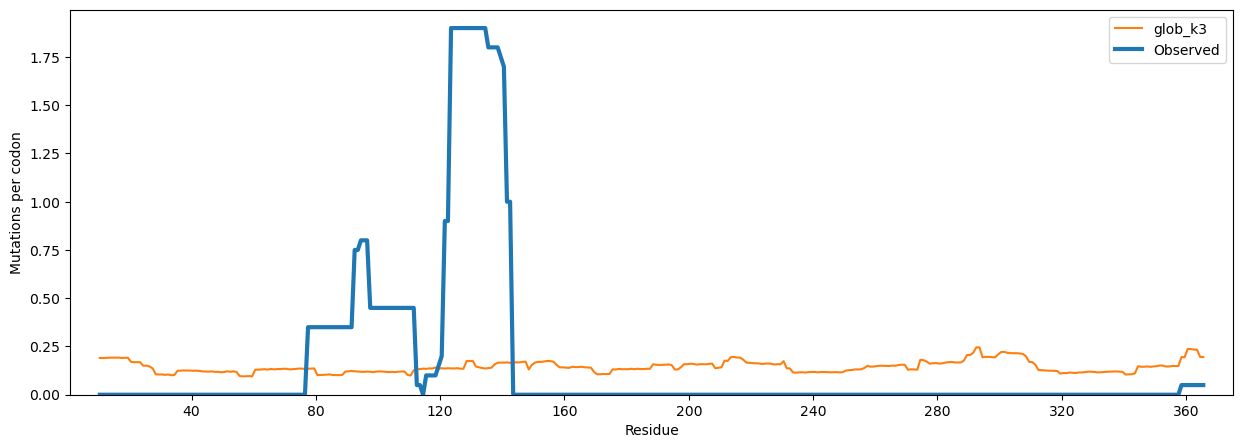

In [15]:
# See where the mutations are
SPOP.plot_sliding_window()

In [16]:
from darwinian_shift import FoldXLookup
foldx_lookup = FoldXLookup(foldx_results_directory="./Foldx/", download_sifts=True, sifts_directory=".")

In [17]:
SPOP_structure = {
    "gene":"SPOP",
    "pdb_id":"6I41",
    "pdb_chain": "A"
}

In [18]:
SPOP_binding = d.run_section(SPOP_structure, lookup=foldx_lookup)

In [19]:
SPOP_binding.get_results_dictionary()

{'gene': 'SPOP',
 'transcript_id': 'ENST00000393328',
 'chrom': '17',
 'section_id': '6I41:A',
 'num_mutations': 54,
 'observed_median': 0.5242499999999994,
 'observed_mean': 1.2904566666666666,
 'expected_median_glob_k3': 0.0028000000000005,
 'median_shift_glob_k3': 0.521449999999999,
 'expected_mean_glob_k3': 0.35780128932329586,
 'mean_shift_glob_k3': 0.9326553773433708,
 'CDF_MC_glob_k3_num_smaller_or_equal': 10001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 0.00019998000199980003,
 'CDF_MC_glob_k3_cdf_mean': 0.8047422522297852}

In [21]:
SPOP_binding.get_pvalues()

{'CDF_MC_glob_k3_pvalue': 0.00019998000199980003}

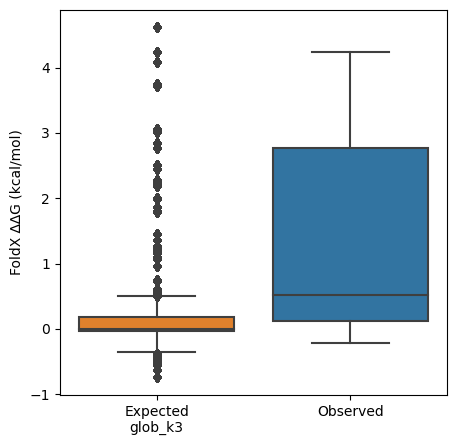

In [22]:
SPOP_binding.plot_boxplot()

## Reading in Endometrial TCGA data

In [23]:
## We load the endometrial cancer data
# We get this from: https://xenabrowser.net/datapages/?dataset=mc3%2FUCEC_mc3.txt&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
endometrial_data = pd.read_csv("UCEC_mc3.txt", sep = "\t")
## Get only missense mutations
endometrial_data_missense = endometrial_data[endometrial_data["effect"] == "Missense_Mutation"]

In [24]:
## We format the dataframe to look as darwinian shift expects (https://github.com/michaelhall28/darwinian_shift/wiki/Mutation-data)
endometrial_data_missense.columns = ["sample", "chr", "pos", "end", "ref", "mut", "gene", "effect"
                                  , "Amino_Acid_Change", "DNA_VAF", "SIFT", "PolyPhen"]

In [25]:
## Calculate the base signature:

d_endo = darwinian_shift.DarwinianShift(data = endometrial_data_missense, source_genome="GRCh37")

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/darwinian_shift/general_functions.py:548: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  intersection = exon_bed.intersect(mut_bed).to_dataframe()


In [26]:
SPOP_endo = d_endo.make_section(gene="SPOP")

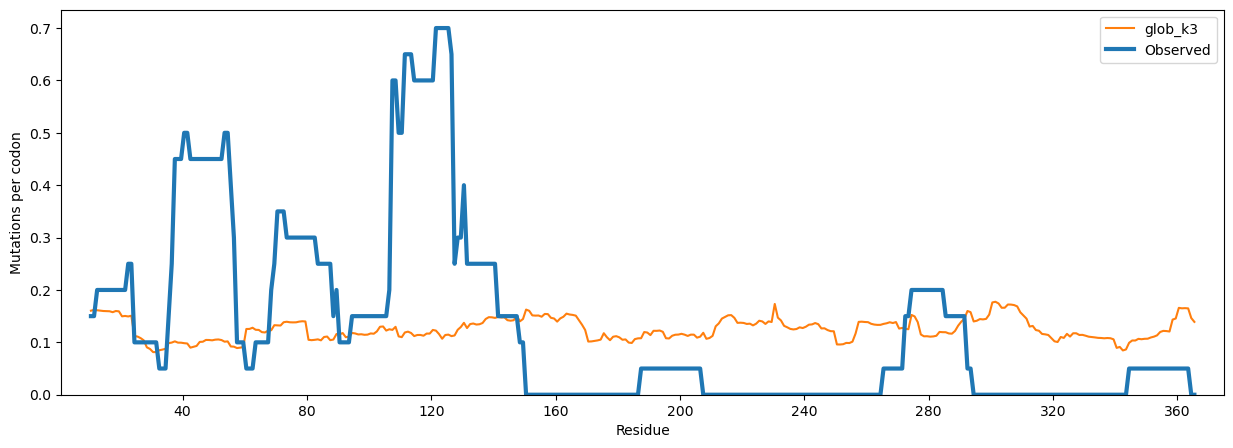

In [27]:
## Look at distribution of mutations
SPOP_endo.plot_sliding_window()

In [28]:
SPOP_binding_endo = d_endo.run_section(SPOP_structure, lookup=foldx_lookup)

In [29]:
SPOP_binding_endo.get_results_dictionary()

{'gene': 'SPOP',
 'transcript_id': 'ENST00000393328',
 'chrom': '17',
 'section_id': '6I41:A',
 'num_mutations': 17,
 'observed_median': -0.0412999999999996,
 'observed_mean': 0.28562352941176444,
 'expected_median_glob_k3': 0.0104000000000006,
 'median_shift_glob_k3': -0.051700000000000204,
 'expected_mean_glob_k3': 0.47602084631696356,
 'mean_shift_glob_k3': -0.19039731690519912,
 'CDF_MC_glob_k3_num_smaller_or_equal': 157,
 'CDF_MC_glob_k3_num_larger_or_equal': 9845,
 'CDF_MC_glob_k3_pvalue': 0.0313968603139686,
 'CDF_MC_glob_k3_cdf_mean': 0.34680365075644765}

In [30]:
SPOP_binding_endo.get_pvalues()

{'CDF_MC_glob_k3_pvalue': 0.0313968603139686}

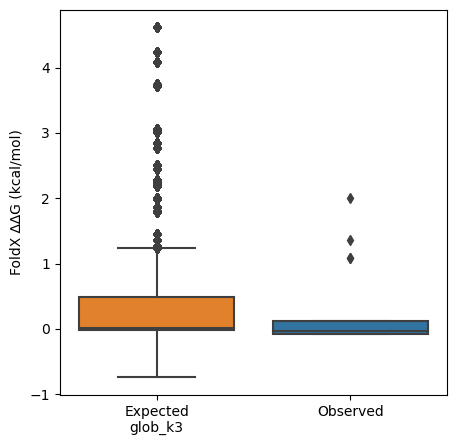

In [31]:
SPOP_binding_endo.plot_boxplot()

## We've calculated our pvalues and statistics - now we hack darwinian shift a lot to make some prettier plots

In [32]:
## Fancy plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [33]:
data_prostate = plot_boxplot2(SPOP_binding)
data_endo = plot_boxplot2(SPOP_binding_endo)

basedistprostate = data_prostate[0]
prostatedist = data_prostate[1]

basedistendo = data_endo[0]
endodist = data_endo[1]

basedistprostate = pd.DataFrame(basedistprostate)
basedistprostate["label"] = "base_prostate"
basedistprostate.columns = ["score", "label"]

basedistendo = pd.DataFrame(basedistendo)
basedistendo["label"] = "base_endo"
basedistendo.columns = ["score", "label"]

prostatedist = pd.DataFrame(prostatedist)
prostatedist["label"] = "prostate"

endodist = pd.DataFrame(endodist)
endodist["label"] = "endo"

testdist_prostate = pd.DataFrame([-15])
testdist_prostate["label"] = "base_prostate"
testdist_prostate.columns = ["score", "label"]

testdist_endo = pd.DataFrame([-15])
testdist_endo["label"] = "base_endo"
testdist_endo.columns = ["score", "label"]

combined = pd.concat([basedistprostate, prostatedist, basedistendo, endodist], axis =0)
combined2 = pd.concat([testdist_prostate, prostatedist,testdist_endo, endodist], axis =0)

/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_13579/592325255.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels([-1,0,1,2,3,4,5], size = 14)


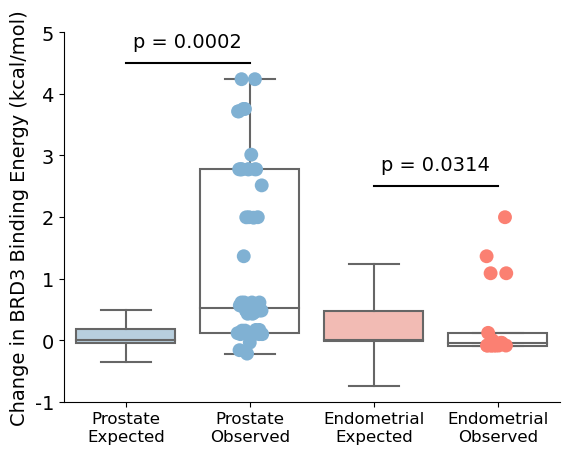

In [35]:
fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


g = sns.boxplot(data = combined, x = "label", y = "score"
                , palette = [sns.color_palette("Set3")[4], "w", sns.color_palette("Set3")[3], "w"], showfliers = False)
for patch in ax.patches:
    r, g1, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g1, b, 0.6))

g2 = sns.stripplot(data = combined2, x = "label", y = "score", palette=["w", sns.color_palette("Set3")[4], "w", sns.color_palette("Set3")[3]], size = 10)

x1, x2 = 0, 1  
y, h, col = 4.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.0002", ha='center', va='bottom', color=col, size = 14)


x1, x2 = 2, 3  
y, h, col = 2.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.0314", ha='center', va='bottom', color=col, size = 14)

g.set_xlabel("")
g.set_xticklabels(["Prostate\nExpected", "Prostate\nObserved", "Endometrial\nExpected", "Endometrial\nObserved"], size = 12)

g.set_ylabel("Change in BRD3 Binding Energy (kcal/mol)", size = 14)
g.set_yticklabels([-1,0,1,2,3,4,5], size = 14)
#ax.set_yscale("symlog")
ax.set_ylim(-1, 5)
sns.despine()
plt.savefig("SPOP_ligandbinding_cancermutations_v1.pdf")